##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: Image-to-image translation with a conditional GAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Notes:

* Note that `load_image_train` and `load_image_test` are different. One does `random_jitter` and the other does `resize`.

## To do

- [x] Use only one channel rather than $3$. Change the image shape from `(256, 256, 3)` to `(256, 256, 1)` 
- [x] Try cutting the image so that the size is not power of $2$. For each `image`, try using `image[:200, :200, :1]`. <font color='red'> The problem is, if not power of $2$, when you downsample to $1$ (not sure if it's necessary to go all the way to $1$) and then upsample, at some step you won't be able to concatenate `up` and `skip` because `skip`'s shape' is odd and `up`'s shape is even. <font> Instead, use `input_image[128:, 128:, :1]` and `target_image`.
- [ ] Train the NN using input and output images that have different shapes. Try pairing `input_image[:200, :200, :1]` with `target_image[-150:, -150:, :1]`.
- [ ] We need to adjust UNet's structure or change the architecture completely. The application of cGAN depends on its architecture.

## Questions:
- [ ] <font color='red'> `snr = read_snr(snr_file)` sometimes has `ValueEror` </font>
- [ ] <font color='red'> What if we set `strides=1` rather than `strides=2` So the shape of images is not restricted by power of $2$. </font> Need to look up the UNet paper.
- [x] <font color='red'> Could not understand what `Build an input pipeline with tf.data` part is doing? </font>
- [ ] <font color='red'> What are `Batch normalization` and `LeakyRelu`? </font>
- [ ] <font color='red'> Don't understand what `training=True` do. In the [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model), it says If you subclass Model, you can optionally have a training argument (boolean) in call(), which you can use to specify a different behavior in training and inference: </font>
- [x] <font color='red'>  In `def fit, for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():` each item in the dataset is a tuple that contains input_image and target_image, right? When tensorflow reads training images, how does it know to unpack input_image and output_image? Does `EagerTensor` type help? </font> <font color='green'> This step converts each image to a tuple: `train_dataset = train_dataset.map(load_image_train, ...)` </font>
```
class MyModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
    self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, inputs, training=False):
    x = self.dense1(inputs)
    if training:
      x = self.dropout(x, training=training)
    return self.dense2(x)

model = MyModel()
```
* the `training` argument in `tf.keras.layers.Dropout` is Python boolean indicating whether the layer should behave in training mode (adding dropout) or in inference mode (doing nothing).
- [ ] <font color='red'> In the `random_crop` step, is that okay if the `input_image` and `output_image` are cropped individually? <font>
- [ ] <font color='red'> No idea how pick the number of filters and the size of each filter in CNN. </font>

## Import TensorFlow and other libraries

In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## Load SNR and skymap dataset

In [3]:
import numpy as np
import astropy_healpix as ah
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
from ligo.skymap.io import fits   # 'ligo.skymap.io.fits' has no attribute 'open'
                                  # 'astropy.io.fits' has no 'read_sky_map'
# import fits
# from fits import read_sky_map

import ligo.skymap.plot
import healpy
import sys

### Read skymap array

In [4]:
def read_skymap(file):

    from ligo.skymap.io import fits
    skymap, metadata = fits.read_sky_map(file)

    # print(metadata.keys())   
        # odict_keys(['HISTORY', 'objid', 'instruments',  'gps_time', 
        # 'gps_creation_time', 'creator', 'origin', 'runtime', 'distmean', 
        # 'diststd', 'log_bci', 'log_bsn', 'vcs_version', 'nest'])

    return skymap

def plot_skymap(skymap):
    
    nside = ah.npix_to_nside(len(skymap))

    # Convert sky map from probability to probability per square degree.
    deg2perpix = ah.nside_to_pixel_area(nside).to_value(u.deg**2)
    probperdeg2 = skymap / deg2perpix
    
    ax = plt.axes(
        [0.05, 0.05, 0.9, 0.9],
        projection='astro mollweide')
    ax.grid()

    # Plot sky map.
    vmax = probperdeg2.max()

    img = ax.imshow_hpx(
        # nested=metadata['nest'], vmin=0., vmax=vmax
        # cmap='cylon',
        (probperdeg2, 'ICRS'), cmap='cylon', # nested=metadata['nest'],   # don't know what 'ICRS' is used for
        vmin=0., vmax=vmax)

# convert the skymap array to probability array
def prob_per_deg(skymap):
    
    nside = ah.npix_to_nside(len(skymap))

    # Convert sky map from probability to probability per square degree.
    deg2perpix = ah.nside_to_pixel_area(nside).to_value(u.deg**2)
    probperdeg2 = skymap / deg2perpix

    return probperdeg2

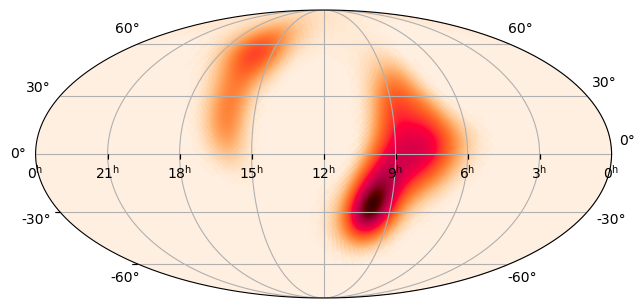

In [5]:
path = '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/process_dag/bayestar-localize-coincs/10000/'
test_file = f'{path}1000002229.fits'
skymap_test = read_skymap(test_file)
plot_skymap(skymap_test)

### Read SNR

In [6]:
import numpy as np
from ligo.lw import ligolw
from ligo.lw import lsctables
from ligo.lw import array as ligolw_array
from ligo.lw import param as ligolw_param
from ligo.lw import utils as ligolw_utils
from lal import series as lalseries
import lal

In [7]:
def read_snr(file):
    
    xmldoc = ligolw_utils.load_filename(file, 
        contenthandler=ligolw.LIGOLWContentHandler, verbose=True)
    
    Elem = xmldoc.getElementsByTagName(ligolw.LIGO_LW.tagName)
    
    tot = 3*1401
    time = np.zeros(tot)
    real = np.zeros(tot)
    imag = np.zeros(tot)
    
    for i in range(3):
        
        elem = Elem[i] # i = 0 is the first detector (H1)

        t, = elem.getElementsByTagName(ligolw.Time.tagName)
        f0 = elem.getElementsByTagName(ligolw.Param.tagName)
        a, = elem.getElementsByTagName(ligolw.Array.tagName)  

        epoch = t.pcdata  ## this is t = 0

        dims = a.getElementsByTagName(ligolw.Dim.tagName)
        t_len = dims[0].n  ## this is length of the array
        deltaT = dims[0].Scale ## this is delta T between each array element

        s = a.getElementsByTagName(ligolw.Stream.tagName)
        lines = s[0].pcdata.split('\n')
        data = [l.split('\t')[4] for l in lines[1:-1]]
        time[1401*i : 1401*(i + 1)] = np.array([float(t.split(" ")[0]) for t in data])
        real[1401*i : 1401*(i + 1)] = np.array([float(d.split(" ")[1]) for d in data])
        imag[1401*i : 1401*(i + 1)] = np.array([float(d.split(" ")[2]) for d in data])
        array = [float(d.split(" ")[1]) + 1j * float(d.split(" ")[2]) for d in data] # this is the actual timeseries snr = z(t)
        array = np.array(array)

        # this is a complex8 time series object used in ligo, not necessarily important for now, this step initializes it
        ts = lal.CreateCOMPLEX8TimeSeries(a.Name, epoch, float(f0[0].pcdata), 
                                          dims[0].Scale, lal.Unit(str(dims[0].Unit)), 
                                          dims[0].n) 
        # add the snr time series to the complex8 time series object
        ts.data.data = array
        
        snr = np.stack((time, real, imag))
    
    # return time, array
    return snr

In [8]:
test_file = '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/\
data/29/gstlal-snr-series/10000/223_1000002229_event.xml.gz'
snr_test = read_snr(test_file)

reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/223_1000002229_event.xml.gz' ...


### Loop through training data

In [9]:
from os import listdir
from os.path import isfile, isdir, join

In [10]:
frequency = ['29', '32', '38', '49', '56', '1024']

def load_train_data():

    snr_all = []
    skymap_all = []
    
    for fre in frequency[:1]:   # [:1] only does 29/ for now
        path = '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/' \
             + fre
        snr_path0 = path + '/gstlal-snr-series/'
        skymap_path0 = path + '/process_dag/bayestar-localize-coincs/'
        snr_dirs = [d for d in listdir(snr_path0) if isdir(join(snr_path0, d))]
        skymap_dirs = [d for d in listdir(skymap_path0) if isdir(join(skymap_path0, d))]
        # sort the directory and file names so the SNR.xml and skymap.fits files 
        # can come in pairs
        snr_dirs.sort()
        skymap_dirs.sort()

        for snr_dir, skymap_dir in zip(snr_dirs, skymap_dirs):
            print(snr_dir, skymap_dir)
            snr_path = snr_path0 + snr_dir + '/'
            snr_files = [f for f in listdir(snr_path) if isfile(join(snr_path, f))]
            snr_files.sort(key=lambda file: file[-18:])

            skymap_path = skymap_path0 + skymap_dir + '/'
            skymap_files = [f for f in listdir(skymap_path) if isfile(join(skymap_path, f))]
            skymap_files.sort()

            for i, (snr_fname, skymap_fname) in enumerate(zip(snr_files, 
                                                              skymap_files)):
                # double check the snr file and skymap file match
                assert snr_fname[-18:-13] == skymap_fname[-10:-5], \
                    print('snr_fname =', snr_fname, 'skymap_fname', skymap_fname)
                
                snr_file = snr_path + snr_fname
                skymap_file = skymap_path + skymap_fname

                # read data
                # Some files have 'ValueError'. Need to deal with it later
                try:
                    snr = read_snr(snr_file)
                except ValueError:
                    print('ValueError', snr_file)
                    continue
                skymap = read_skymap(skymap_file)
                # print(skymap_fname, skymap.shape)
                
                # reshape and append data
                img_shape = (3, 65536)
                snr_tmp = np.ones(img_shape)
                
                # only use the SNR dataset whose size is (196608,)
                if skymap.shape == (196608,):
                    snr_tmp[:, :4203] = snr
                    snr_all.append(snr_tmp)
                    skymap = skymap.reshape(img_shape)
                    skymap_all.append(skymap)
                        
    return np.array(snr_all, dtype=np.float32), np.array(skymap_all, dtype=np.float32)

In [11]:
snr_all, skymap_all = load_train_data()

reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/220_1000002199_event.xml.gz' ...


10000 10000


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/223_1000002229_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/273_1000002729_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/327_1000003270_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/537_1000005369_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/575_1000005749_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/614_1000006139_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10000/640_1000006399_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/p

10001 10001


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10001/10166_1000101660_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10001/10184_1000101840_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10001/10255_1000102549_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10001/11101_1000111009_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10001/11180_1000111799_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10001/11286_1000112860_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10001/11307_1000113069_event.xml.gz' ...
reading '/Users/yunlin/Drop

10002 10002


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10002/20009_1000200089_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10002/20124_1000201239_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10002/20196_1000201960_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10002/20202_1000202019_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10002/20360_1000203600_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10002/20935_1000209350_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10002/21130_1000211300_event.xml.gz' ...
reading '/Users/yunlin/Drop

10003 10003


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10003/30436_1000304359_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10003/30524_1000305240_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10003/30609_1000306090_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10003/30739_1000307390_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10003/30979_1000309790_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10003/31091_1000310910_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10003/31141_1000311409_event.xml.gz' ...
reading '/Users/yunlin/Drop

10004 10004


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10004/40394_1000403940_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10004/40468_1000404679_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10004/40506_1000405060_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10004/40873_1000408729_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10004/40879_1000408790_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10004/41007_1000410069_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10004/41210_1000412100_event.xml.gz' ...
reading '/Users/yunlin/Drop

10005 10005


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10005/50108_1000501079_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10005/50241_1000502410_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10005/50246_1000502460_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10005/50421_1000504209_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10005/50493_1000504930_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10005/50567_1000505669_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10005/50814_1000508140_event.xml.gz' ...
reading '/Users/yunlin/Drop

10006 10006


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10006/60157_1000601570_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10006/60337_1000603370_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10006/60379_1000603790_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10006/60616_1000606159_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10006/60636_1000606359_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10006/60659_1000606590_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10006/60711_1000607109_event.xml.gz' ...
reading '/Users/yunlin/Drop

10007 10007


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10007/70223_1000702229_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10007/70256_1000702559_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10007/70346_1000703459_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10007/70485_1000704850_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10007/70489_1000704889_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10007/70502_1000705019_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10007/70691_1000706909_event.xml.gz' ...
reading '/Users/yunlin/Drop

10008 10008


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10008/80410_1000804099_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10008/80473_1000804730_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10008/80645_1000806450_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10008/80657_1000806569_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10008/80945_1000809449_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10008/81084_1000810839_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10008/81086_1000810860_event.xml.gz' ...
reading '/Users/yunlin/Drop

10009 10009


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10009/90146_1000901460_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10009/90207_1000902069_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10009/90417_1000904170_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10009/90418_1000904180_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10009/90427_1000904269_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10009/90630_1000906299_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10009/90763_1000907630_event.xml.gz' ...
reading '/Users/yunlin/Drop

10010 10010


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10010/100473_1001004729_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10010/100510_1001005099_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10010/100552_1001005519_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10010/100693_1001006929_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10010/100846_1001008459_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10010/100934_1001009340_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10010/101229_1001012289_event.xml.gz' ...
reading '/Users/yunl

10011 10011


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10011/110122_1001101219_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10011/110141_1001101410_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10011/110208_1001102079_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10011/110210_1001102100_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10011/110436_1001104360_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10011/110516_1001105159_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10011/110771_1001107710_event.xml.gz' ...
reading '/Users/yunl

10012 10012


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10012/120029_1001200289_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10012/120199_1001201989_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10012/120386_1001203859_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10012/120550_1001205500_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10012/120565_1001205649_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10012/120625_1001206249_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10012/120667_1001206670_event.xml.gz' ...
reading '/Users/yunl

10013 10013


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10013/130257_1001302570_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10013/130345_1001303449_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10013/130374_1001303739_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10013/130383_1001303829_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10013/130454_1001304539_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10013/130473_1001304730_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10013/130512_1001305120_event.xml.gz' ...
reading '/Users/yunl

10014 10014


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10014/140587_1001405869_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10014/140713_1001407130_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10014/141012_1001410120_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10014/141142_1001411420_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10014/141170_1001411700_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10014/141464_1001414639_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10014/141481_1001414809_event.xml.gz' ...
reading '/Users/yunl

10015 10015


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10015/150080_1001500800_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10015/150157_1001501569_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10015/150455_1001504550_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10015/150462_1001504619_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10015/150501_1001505009_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10015/150588_1001505880_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10015/150779_1001507790_event.xml.gz' ...
reading '/Users/yunl

10016 10016


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10016/160118_1001601179_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10016/160179_1001601789_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10016/160258_1001602580_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10016/160410_1001604099_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10016/160415_1001604150_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10016/160481_1001604810_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10016/160693_1001606930_event.xml.gz' ...
reading '/Users/yunl

10017 10017


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10017/170264_1001702639_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10017/170405_1001704050_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10017/170467_1001704669_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10017/170471_1001704710_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10017/170531_1001705310_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10017/170570_1001705699_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10017/170712_1001707120_event.xml.gz' ...
reading '/Users/yunl

ValueError /Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10017/179944_1001799439_event.xml.gz
10018 10018


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10018/180253_1001802530_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10018/180267_1001802670_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10018/180333_1001803329_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10018/180349_1001803489_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10018/180370_1001803700_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10018/180382_1001803820_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10018/180460_1001804600_event.xml.gz' ...
reading '/Users/yunl

10019 10019


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10019/190312_1001903119_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10019/190337_1001903370_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10019/190472_1001904720_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10019/190615_1001906149_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10019/190724_1001907239_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10019/190879_1001908789_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10019/190900_1001908999_event.xml.gz' ...
reading '/Users/yunl

10020 10020


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10020/200419_1002004190_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10020/200520_1002005199_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10020/200620_1002006199_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10020/200697_1002006969_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10020/200725_1002007250_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10020/200746_1002007459_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10020/201009_1002010090_event.xml.gz' ...
reading '/Users/yunl

10021 10021


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10021/210126_1002101260_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10021/210518_1002105179_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10021/210761_1002107609_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10021/210842_1002108420_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10021/210844_1002108439_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10021/210868_1002108679_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10021/210889_1002108889_event.xml.gz' ...
reading '/Users/yunl

10022 10022


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10022/220369_1002203690_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10022/220772_1002207719_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10022/220773_1002207729_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10022/220881_1002208809_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10022/220974_1002209739_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10022/221024_1002210240_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10022/221215_1002212149_event.xml.gz' ...
reading '/Users/yunl

10023 10023


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10023/230010_1002300099_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10023/230067_1002300669_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10023/230131_1002301309_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10023/230293_1002302930_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10023/230547_1002305469_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10023/230711_1002307109_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10023/230834_1002308340_event.xml.gz' ...
reading '/Users/yunl

10024 10024


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10024/240550_1002405499_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10024/240560_1002405600_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10024/240810_1002408099_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10024/240906_1002409060_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10024/241113_1002411129_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10024/241205_1002412050_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10024/241348_1002413480_event.xml.gz' ...
reading '/Users/yunl

10025 10025


reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10025/250260_1002502599_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10025/250340_1002503399_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10025/250354_1002503540_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10025/250393_1002503930_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10025/250432_1002504320_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10025/250481_1002504809_event.xml.gz' ...
reading '/Users/yunlin/Dropbox (GaTech)/physics/research/skymap/jfs6217/data/29/gstlal-snr-series/10025/250705_1002507050_event.xml.gz' ...
reading '/Users/yunl

In [12]:
# snr_all = np.array(snr_all)
# skymap_all = np.array(skymap_all)

len_all = len(snr_all)
len_train = 1000
len_test = len_all - len_train   # 16

snr_train = snr_all[:len_train]
snr_test = snr_all[len_train:]
skymap_train = skymap_all[:len_train]
skymap_test = skymap_all[len_train:]

print(len(snr_all), len(skymap_all))
print(snr_all.shape, skymap_all.shape)

1016 1016
(1016, 3, 65536) (1016, 3, 65536)


In [13]:
print(type(snr_all[0][0][0]))

<class 'numpy.float32'>


In [14]:
img_height = 3
img_width = int(196608/3)   # 65536
img_depth = 1
resize_height = 3
resize_width = int(3*1401*3*16/3)   # 67248

# train_ds = np.ones((len_snr_train*3, 2*img_length))   # 3*1401*3*16 = 201744
# test_ds = np.ones((len_snr_test*3, 2*img_length))
# for i, (snr, skymap) in enumerate(zip(snr_all, skymap_all)):
#     train_ds[i:i+3, :1401*3] = snr
#     train_ds[i][img_length:img_length+65536] = skymap[:65536]   # 196608/3 = 65536
#     train_ds[i+1][:65536] = skymap[65536:65536*2]
#     train_ds[i+2][:65536] = skymap[65536*2:65536*3]
    
# train_ds = tf.data.Dataset.from_tensors(train_ds)
# test_ds = tf.data.Dataset.from_tensors(test_ds)

# The facade training set consist of 400 images
# BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
# BATCH_SIZE = 1

## Build an input pipeline with `tf.data`

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}, you need to <font color='red'> apply random jittering and mirroring to preprocess the training set. </font>

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [15]:
# for sanity check
# inp, re = snr_test, skymap_test   # also need reshape

In [16]:
def load(input_img, target):

    # - one with SNR
    # - one with skymap array

    # Convert both images to float32 tensors
    input_img = tf.cast(input_img, tf.float32)
    target = tf.cast(target, tf.float32)

    return input_img, target

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, img_height, img_width, img_depth])

    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing
    input_image, real_image = resize(input_image, real_image, resize_width, resize_height)

    # Random cropping back to original shape
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [17]:
def load_image_train(input_img, target):
    
    input_image, real_image = load(input_img, target)
    # input_image, real_image = random_jitter(input_image, real_image)
    # input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(input_img, target):
    
    input_image, real_image = load(input_img, target)
    # input_image, real_image = resize(input_image, real_image,
    #                                img_height, img_width)
    # input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

# process all images
for i, (input_img, target) in enumerate(zip(snr_train, skymap_train)):
    input_img, target = load_image_train(input_img, target)
    snr_train[i] = input_img
    skymap_train[i] = target

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597){:.external}. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}.)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [18]:
OUTPUT_CHANNELS = 1
strides = 1   # equals to 2 for pix2pix
size = 3   # size of filter

In [19]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [20]:
# test downsample
down_model = downsample(3, 3)
# down_result = down_model(tf.expand_dims(inp, 0))
# print(down_result.shape)

Define the upsampler (decoder):

In [21]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                padding='same',
                                kernel_initializer=initializer,
                                use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [22]:
# test upsample
up_model = upsample(3, 3)
# up_result = up_model(down_result)
# print(up_result.shape)

Define the generator with the downsampler and the upsampler (remember `strides=2`):

In [23]:
def Generator(size=size):
  inputs = tf.keras.layers.Input(shape=[img_height, img_width, img_depth])

  down_stack = [
    # downsample(64, size, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    # downsample(128, size),  # (batch_size, 64, 64, 128)
    # downsample(256, size),  # (batch_size, 32, 32, 256)
    # downsample(512, size),  # (batch_size, 16, 16, 512)
    # downsample(512, size),  # (batch_size, 8, 8, 512)
    # downsample(512, size),  # (batch_size, 4, 4, 512)
    # downsample(512, size),  # (batch_size, 2, 2, 512)
    # downsample(512, size),  # (batch_size, 1, 1, 512)
    downsample(64, 4, apply_batchnorm=False),
    downsample(128, 4)
  ]

  up_stack = [
    upsample(128, 4, apply_dropout=True),
    upsample(64, 4)
    # upsample(512, size, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    # upsample(512, size, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    # upsample(512, size, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    # upsample(512, size),  # (batch_size, 16, 16, 1024)
    # upsample(256, size),  # (batch_size, 32, 32, 512)
    # upsample(128, size),  # (batch_size, 64, 64, 256)
    # upsample(64, size),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=strides,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    print(x.shape)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    print(x.shape, skip.shape)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

(None, 3, 65536, 64)
(None, 3, 65536, 128)
(None, 3, 65536, 128) (None, 3, 65536, 64)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [25]:
# import pydot, graphviz

Test the generator:

In [26]:
# gen_output = generator(inp[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])

### Define the generator loss

<font color='blue'> GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.</font>

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- <font color='blue'> This allows the generated image to become structurally similar to the target image. </font>
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [27]:
LAMBDA = 100

In [28]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

<font color='blue'> The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier</font>—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- <font color='red'> The shape of the output after the last layer is `(batch_size, 30, 30, 1)`. </font>
- <font color='red'> Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image. </font>
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [30]:
def Discriminator(size=size):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[img_height, img_width, img_depth], name='input_image')
  tar = tf.keras.layers.Input(shape=[img_height, img_width, img_depth], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, img_height, img_width, channels*2)

  down1 = downsample(64, size, False)(x)  # (batch_size, 128, 128, 64)
  # down2 = downsample(128, size)(down1)  # (batch_size, 64, 64, 128)
  # down3 = downsample(256, size)(down2)  # (batch_size, 32, 32, 256)

#   zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
#   conv = tf.keras.layers.Conv2D(512, size, strides=strides,
#                                 kernel_initializer=initializer,
#                                 use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

#   batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

#   leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

#   zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

#   last = tf.keras.layers.Conv2D(1, 4, strides=1,
#                                 kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
  last = tf.keras.layers.Conv2D(1, size, strides=1, padding='same', 
                                kernel_initializer=initializer)(down1)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

In [31]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Test the discriminator:

In [32]:
# disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
# plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

sigmoid cross-entropy loss is also called binary cross-entropy loss

In [33]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [34]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [35]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

<font color='red'> Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want). </font>

In [36]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    # display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

#     for i in range(3):
#         plt.subplot(1, 3, i+1)
#         plt.title(title[i])
#         # Getting the pixel values in the [0, 1] range to plot.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
#         plt.axis('off')

#     plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    

In [37]:
print('hi')

hi


Test the function:

In [38]:
# for example_input, example_target in test_dataset.take(1):
#     generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`. 
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [39]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, step):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [41]:
def fit(snr_train, skymap_train, snr_test, skymap_test, steps):
    
    # example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_img, target) in enumerate(zip(snr_train, skymap_train)):
        train_step(input_img[np.newaxis, ..., np.newaxis], target[np.newaxis, ..., np.newaxis], step)
        
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time() - start:.2f} sec\n')
            
            start = time.time()
            
            # generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        # Training step
        elif (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        elif (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

In [42]:
from collections.abc import Mapping
%load_ext tensorboard
%tensorboard --logdir {log_dir}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/Users/yunlin/anaconda3/envs/work/bin/tensorboard", line 6, in <module>
    from tensorboard.main import run_main
  File "/Users/yunlin/anaconda3/envs/work/lib/python3.10/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/Users/yunlin/anaconda3/envs/work/lib/python3.10/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/Users/yunlin/anaconda3/envs/work/lib/python3.10/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 23, in <module>
    from tensorboard import plugin_util
  File "/Users/yunlin/anaconda3/envs/work/lib/python3.10/site-packages/tensorboard/plugin_util.py", line 20, in <module>
    from tensorboard._vendor.bleach.sanitizer import Cleaner
  File "/Users/yunlin/anaconda3/envs/work/lib/python3.10/site-packages/tensorboard/_vendor

Finally, run the training loop:

In [43]:
fit(snr_train, skymap_train, snr_test, skymap_test, steps=500)

Step: 0k
....................................................................................................

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

[TensorBoard.dev](https://tensorboard.dev){:.external} is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [44]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [45]:
!ls {checkpoint_dir}

ls: ./training_checkpoints: No such file or directory


In [46]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

-0.29616642


SystemExit: 

/Users/yunlin/anaconda3/envs/skymap/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


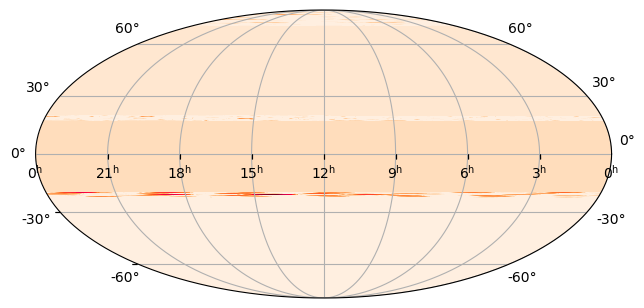

In [57]:
# Run the trained model on a few examples from the test set
for inp, tar in zip(snr_test, skymap_test):
    gen_output = generator(inp[tf.newaxis, ...], training=False)
    gen_output = np.array(gen_output[0, ..., 0]).reshape(196608)
    print(min(gen_output))
    plot_skymap(gen_output)
    sys.exit()
    generate_images(generator, inp, tar)